In [ ]:
!wget ftp://ftp.cdc.noaa.gov/Datasets/dai_pdsi/pdsi.mon.mean.selfcalibrated.nc
!wget ftp://ftp.cdc.noaa.gov/Datasets/cpc_us_precip/precip.V1.0.mon.mean.nc
!wget ftp://ftp.cdc.noaa.gov/Datasets/ghcncams/air.mon.mean.nc
!wget ftp://ftp.cdc.noaa.gov/Datasets/NARR/Monthlies/monolevel/soilm.mon.mean.nc

In [60]:
import numpy as np
import xarray as xr
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import datetime
from matplotlib import pyplot as plt
import PIL
from PIL import Image
import cartopy.crs as ccrs
import cartopy
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [61]:
ds_d = xr.open_dataset('pdsi.mon.mean.selfcalibrated.nc')
ds_p = xr.open_dataset('precip.V1.0.mon.mean.nc')
ds_t = xr.open_dataset('air.mon.mean.nc')
ds_soil = xr.open_dataset('soilm.mon.mean.nc',drop_variables=['time_bnds'])
df = pd.read_csv('dm_export_20001124_20191124.csv')

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/conventions.py:448: SerializationWarning: variable 'soilm' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  stack_char_dim=stack_char_dim, use_cftime=use_cftime)


## 1. Current condition

In [62]:
img1 = Image.open('EDDI_03mn_20120601.png')
img2 = Image.open('EDDI_03mn_20190601.png')

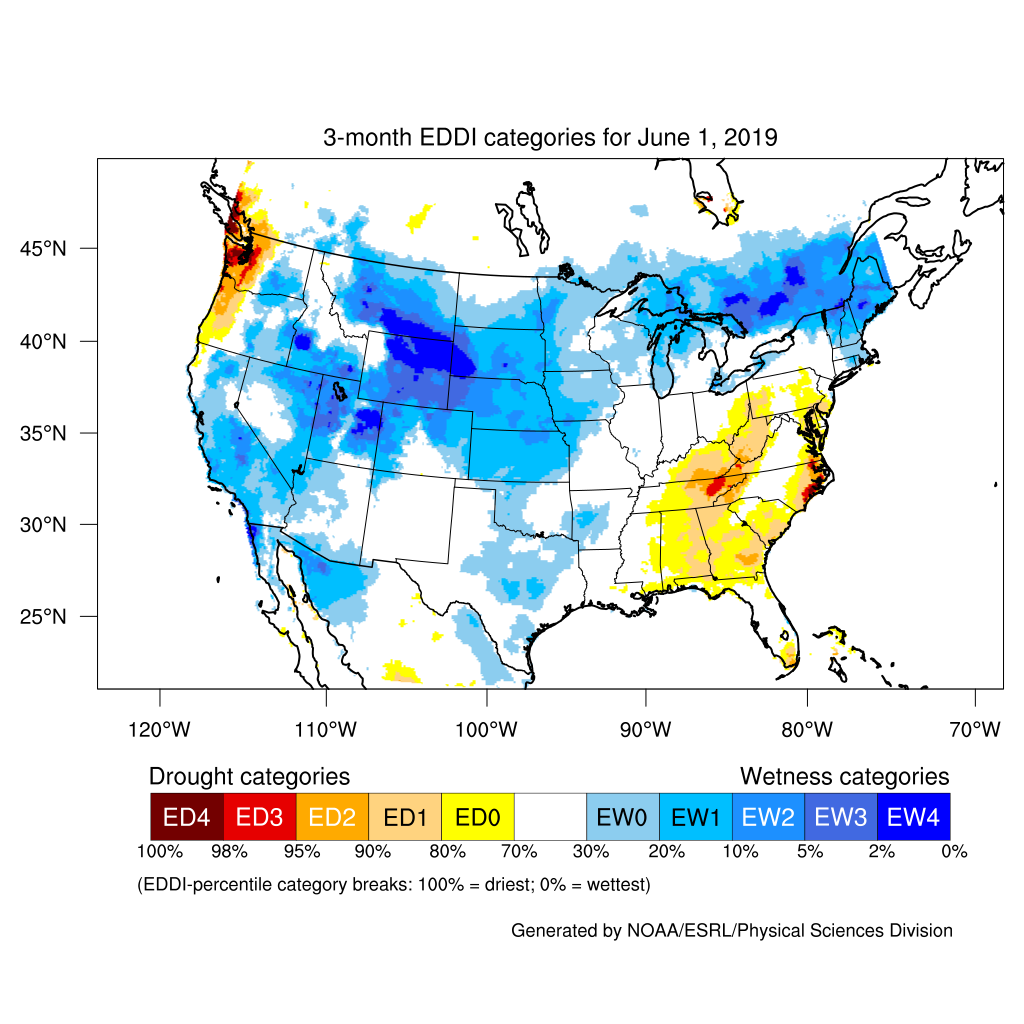

In [63]:
img2

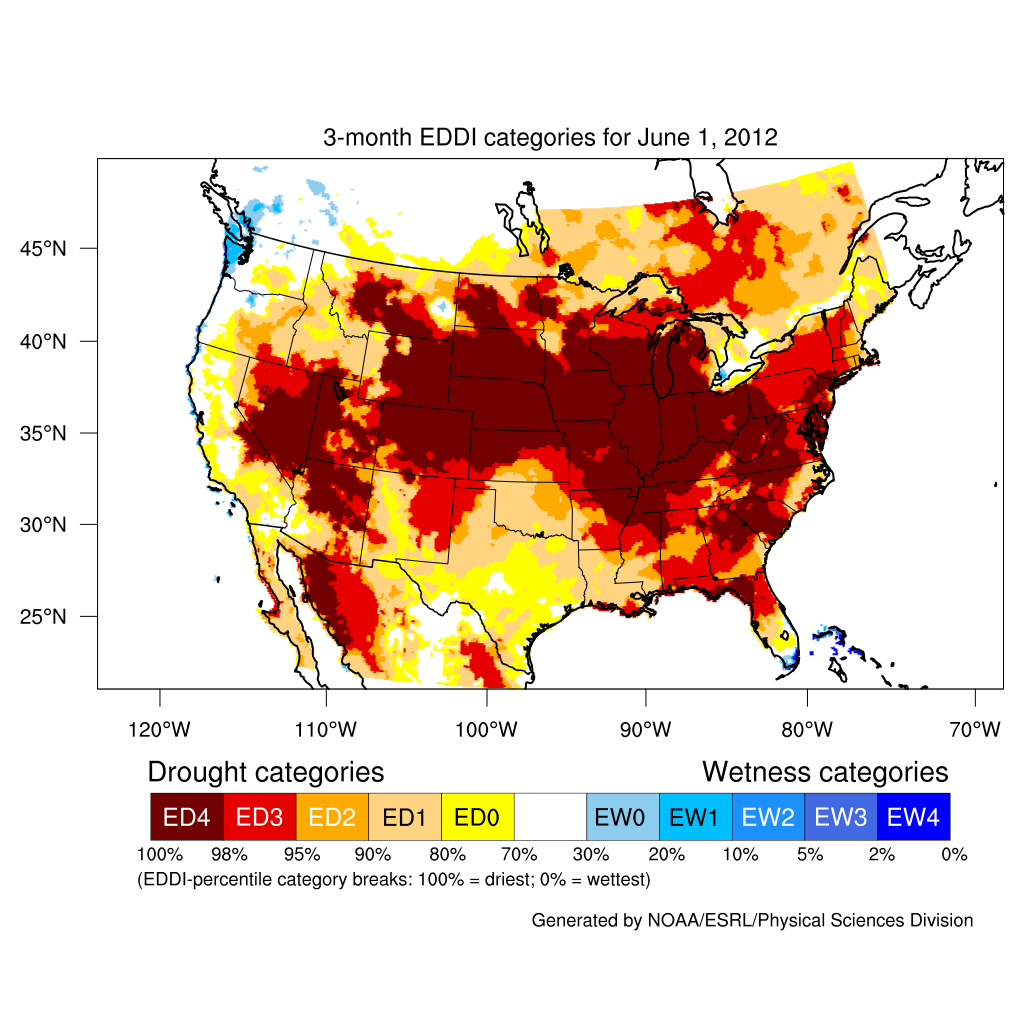

In [64]:
img1

## 2. Drought condition in CONUS (Continential US) from 2000 to 2019

### 2.1 Top 20 Driest Time

In US drought system, 5 different level of drought are defined.  They are abnormally dry (D0), showing areas that may be
going into or are coming out of drought, and four levels of drought: moderate (D1), severe (D2), extreme (D3) and exceptional (D4). Here is the top 20 driest time (D4 level)  in this period. 

In [ ]:
df.nlargest(20,'D4',keep='all')

In [ ]:
df['ValidStart'] = pd.to_datetime(df['ValidStart'])
df1 = df[::-1].set_index('ValidStart')

### 2.2 Drought Precent

In [ ]:
x = df1.index.values
D0 = df1.D0.values
D1 = df1.D1.values
D2 = df1.D2.values
D3 = df1.D3.values
D4 = df1.D4.values

In [ ]:
df1[['D0','D1','D2','D3','D4']].plot(figsize=(30,6),color=['#ffff00','#fcd37f','#ffaa00','#e60000','#730000'])
plt.fill_between(x,D0,D1,color='#ffff00')
plt.fill_between(x,D1,D2,color='#fcd37f')
plt.fill_between(x,D2,D3,color='#ffaa00')
plt.fill_between(x,D3,D4,color='#e60000')
plt.fill_between(x,D4,0,color='#730000')
plt.ylim(0)
plt.xlabel('time/year')
plt.ylabel('Precent')
plt.title('CONUS Precent Area',fontsize=15)

### 2.3 drought anomaly

The Palmer Drought Severity Index (PDSI) : it uses readily available temperature and precipitation data to estimate relative dryness. It is a standardized index that generally spans -10 (dry) to +10 (wet).

In [ ]:
ds_d_area = ds_d.sel(lon=slice(-130,-70),lat=slice(25,50))
ds_d_area_mean = ds_d_area.pdsi.mean(dim=('lon','lat'))

In [ ]:
gb_d = ds_d_area_mean.groupby('time.month')
ds_d_anom = gb_d - gb_d.mean(dim='time')
ds_d_anom_rl = ds_d_anom.rolling(time=6, center=True).mean()

fig,ax = plt.subplots(figsize=(16,9))
ds_d_anom_rl.plot(ax=ax, linewidth=1, color='k')

ax.set_xlabel('Time/year')
ax.set_title('Drought Anomaly in CONUS',fontsize=20)
ax.set_ylabel('Anomaly')

plt.axhline(y=0.5,linestyle='-.',linewidth=1,color='blue')
plt.axhline(y=-0.5,linestyle='-.',linewidth=1,color='red')
plt.axhline(y=0,linewidth=0.5,color='k')

ax.set_xlim(['2000','2015'])
minorticks_on()
tick_params(direction='in',which='major',width=1,length=4)

## 3. Reasons

### 3.1 Precipitation

#### 3.1.1 Precipitation (2010 - 2019)

In [ ]:
ds_p_time_mean = ds_p.precip.mean(dim=('lon','lat')).rolling(time=12,center=True).mean()
ds_p_time_mean.plot(figsize=(12,8))
plt.axhline(y=2.065799,linestyle='--',linewidth=1,color='red')
plt.xlim(['2009','2018'])
plt.title('Precipitation')

#### 3.1.2 Precipitation distribution in Summer from 2010 to 2013

In [ ]:
extent = [-124, -75, 22, 50]
map_proj = ccrs.LambertConformal()

precip_10 = ds_p.sel(time = slice('2010-06-01','2010-08-31')).precip.mean(dim='time')
precip_11 = ds_p.sel(time = slice('2011-06-01','2011-08-31')).precip.mean(dim='time')
precip_12 = ds_p.sel(time = slice('2012-06-01','2012-08-31')).precip.mean(dim='time')
precip_13 = ds_p.sel(time = slice('2013-06-01','2013-08-31')).precip.mean(dim='time')

fig = plt.figure(figsize = (16,9))
ax1 = fig.add_subplot(221,projection = map_proj)

ax1.coastlines()
ax1.gridlines()
ax1.set_extent(extent)
ax1.add_feature(cartopy.feature.STATES)
precip_10.plot(ax=ax1, transform = ccrs.PlateCarree(),cmap='Blues',cbar_kwargs={'shrink':0.5})
ax1.set_title('Precipiatation in 2010')

ax2 = fig.add_subplot(222,projection=map_proj)
ax2.coastlines()
ax2.gridlines()
ax2.set_extent(extent)
ax2.add_feature(cartopy.feature.STATES)
precip_11.plot(ax=ax2,transform = ccrs.PlateCarree(),cmap='Blues',cbar_kwargs={'shrink':0.5})
ax2.set_title('Precipiatation in 2011')

ax3 = fig.add_subplot(223,projection=map_proj)
ax3.coastlines()
ax3.gridlines()
ax3.set_extent(extent)
ax3.add_feature(cartopy.feature.STATES)
precip_12.plot(ax=ax3, transform = ccrs.PlateCarree(),cmap='Blues',cbar_kwargs={'shrink':0.5})
ax3.set_title('Precipiatation in 2012')

ax4 = fig.add_subplot(224,projection=map_proj)
ax4.coastlines()
ax4.gridlines()
ax4.set_extent(extent)
ax4.add_feature(cartopy.feature.STATES)
precip_13.plot(ax=ax4, transform = ccrs.PlateCarree(),cmap='Blues',cbar_kwargs={'shrink':0.5})
ax4.set_title('Precipiatation in 2013')

### 3.2 temperature

#### 3.2.1 Temperature changing trend

In [ ]:
ds_t_time_mean = ds_t.air.mean(dim=('lon','lat')).rolling(time=60,center=True).mean()
ds_t_time_mean.plot(figsize=(12,8))

#### 3.2.2 Temperature distribution in 2012 Summer

In [ ]:
extent = [-124, -75, 22, 50]
map_proj = ccrs.LambertConformal()

t_12 = ds_t.sel(time = slice('2012-06-01','2012-08-31')).air.mean(dim='time')

fig = plt.figure(figsize = (16,9))

ax1 = plt.axes(projection = map_proj)
ax1.coastlines()
ax1.gridlines()
ax1.set_extent(extent)
ax1.add_feature(cartopy.feature.STATES)
t_12.plot(ax=ax1,transform = ccrs.PlateCarree(),vmax=300,cbar_kwargs={'shrink':0.5})
ax1.set_title('Temperature Distribution in 2012 Summer')

### 3.3 Soil moisture in 2012 Summer

In [ ]:
ds_soil

In [ ]:
extent = [-124, -75, 22, 50]
map_proj = ccrs.LambertConformal(false_easting=5632642.22547,
                                 false_northing=4612545.65137,
                                 central_longitude=-107.0,
                                 central_latitude=50.0,
                                 standard_parallels=[50.,50.])

soil_12 = ds_soil.sel(time = slice('2012-06-01','2012-08-31')).soilm.mean(dim='time')


fig = plt.figure(figsize = (16,9))

ax1 = plt.axes(projection = map_proj)
ax1.coastlines()
ax1.gridlines()
ax1.set_extent(extent)
ax1.add_feature(cartopy.feature.STATES)
soil_12.plot(ax=ax1,cmap='RdYlBu',cbar_kwargs={'shrink':0.5})

## 4. global impact

During 2011 to 2012, the global climate was deeply influented by La NiNa. As a result, the westsouth and eastsouth of US sufferred severe drought. 

In [ ]:
drought = ds_d.sel(time = slice('2011-06-01','2011-08-31')).pdsi.mean(dim='time')
drought.plot(figsize=(16,9),cmap='RdYlBu')